In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
!pip install ACO-Pants
!pip install openpyxl
!pip install pulp
!pip install pyMetaheuristic
import pants
import math
import random
import pulp
import openpyxl
from pyMetaheuristic.algorithm import particle_swarm_optimization
from pyMetaheuristic.test_function import easom
from threading import Thread, Event
from queue import Queue
from concurrent.futures import ThreadPoolExecutor
import copy
import time
from multiprocessing import Process
from multiprocessing import Queue as MPQueue
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ACO-Pants: filename=ACO_Pants-0.5.2-py3-none-any.whl size=18859 sha256=e47b2bbc2fe924537d47990d3c199f72022c7c0f2c53945e51bbb12ea49d1e51
  Stored in directory: /root/.cache/pip/wheels/78/53/ac/2abf9d5dd7db48d3af64179dc0bc0dd46e589387ba58975413
Successfully built ACO-Pants
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.2 MB 11.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 3.2 MB/s 
Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# reading in all the csv files
file = pd.ExcelFile("/content/drive/MyDrive/Bachelor Project/Supply chain logisitcs problem.xlsx")
plant_ports = file.parse("PlantPorts")
order_list = file.parse("OrderList")
products_plants = file.parse("ProductsPerPlant")
vmi_plants = file.parse("VmiCustomers")
freight_rates = file.parse("FreightRates")
wh_cost = file.parse("WhCosts")
wh_capacities = file.parse("WhCapacities")

In [4]:
# Data cleaning for order_list

# order_list format conversion
order_list['TPT'] = order_list['TPT'].astype(int)
order_list['Ship ahead day count'] = order_list['Ship ahead day count'].astype(int)
order_list['Ship Late Day count'] = order_list['Ship Late Day count'].astype(int)
order_list['Unit quantity'] = order_list['Unit quantity'].astype(int)
order_list['Weight'] = order_list['Weight'].astype(float)
# drop nulls form order_list
order_list.dropna(inplace=True)
# drop duplicates from order_list
order_list.drop_duplicates(inplace=True)

# Data cleaning for freight_rates

# freight_rates format conversion
freight_rates['minm_wgh_qty'] = freight_rates['minm_wgh_qty'].astype(int)
freight_rates['max_wgh_qty'] = freight_rates['max_wgh_qty'].astype(float)
freight_rates['minimum cost'] = freight_rates['minimum cost'].astype(float)
freight_rates['rate'] = freight_rates['rate'].astype(float)
freight_rates['tpt_day_cnt'] = freight_rates['tpt_day_cnt'].astype(int)
# drop nulls form freight_rates
freight_rates.dropna(inplace=True)
# drop duplicates from freight_rates
freight_rates.drop_duplicates(inplace=True)

# Data cleaning for wh_cost

# wh_cost format conversion
wh_cost['Cost/unit'] = wh_cost['Cost/unit'].astype(float)
# drop nulls form wh_cost
wh_cost.dropna(inplace=True)
# drop duplicates from wh_cost
wh_cost.drop_duplicates(inplace=True)

# Data cleaning for wh_capacities

# wh_cost format conversion
wh_capacities['Daily Capacity '] = wh_capacities['Daily Capacity '].astype(int)
# drop nulls form wh_capacities
wh_capacities.dropna(inplace=True)
# drop duplicates from wh_capacities
wh_capacities.drop_duplicates(inplace=True)

# Data cleaning for products_plants

# drop nulls form products_plants
products_plants.dropna(inplace=True)
# drop duplicates from products_plants
products_plants.drop_duplicates(inplace=True)

# Data cleaning for vmi_plants

# drop nulls form vmi_plants
vmi_plants.dropna(inplace=True)
# drop duplicates from vmi_plants
vmi_plants.drop_duplicates(inplace=True)

# Data cleaning for

# drop nulls form plant_ports
plant_ports.dropna(inplace=True)
# drop duplicates from plant_ports
plant_ports.drop_duplicates(inplace=True)

In [5]:
print(order_list.head().T)

                                        0                    1  \
Order ID                     1447296446.7         1447158014.7   
Order Date            2013-05-26 00:00:00  2013-05-26 00:00:00   
Origin Port                        PORT09               PORT09   
Carrier                             V44_3                V44_3   
TPT                                     1                    1   
Service Level                         CRF                  CRF   
Ship ahead day count                    3                    3   
Ship Late Day count                     0                    0   
Customer                        V55555_53            V55555_53   
Product ID                        1700106              1700106   
Plant Code                        PLANT16              PLANT16   
Destination Port                   PORT09               PORT09   
Unit quantity                         808                 3188   
Weight                               14.3                87.94   

         

In [6]:
print(freight_rates.head().T)

                        0            1            2            3            4
Carrier            V444_6       V444_6       V444_6       V444_6       V444_6
orig_port_cd       PORT08       PORT08       PORT08       PORT08       PORT08
dest_port_cd       PORT09       PORT09       PORT09       PORT09       PORT09
minm_wgh_qty          250           65           60           50           35
max_wgh_qty        499.99        69.99        64.99        54.99        39.99
svc_cd                DTD          DTD          DTD          DTD          DTD
minimum cost      43.2272      43.2272      43.2272      43.2272      43.2272
rate               0.7132       0.7512       0.7892       0.8272       1.0552
mode_dsc           AIR          AIR          AIR          AIR          AIR   
tpt_day_cnt             2            2            2            2            2
Carrier type  V88888888_0  V88888888_0  V88888888_0  V88888888_0  V88888888_0


In [7]:
print(wh_cost.head().T)

                  0         1         2         3         4
WH          PLANT15   PLANT17   PLANT18   PLANT05   PLANT02
Cost/unit  1.415063  0.428947  2.036254  0.488144  0.477504


In [8]:
print(wh_cost.head().T)

                  0         1         2         3         4
WH          PLANT15   PLANT17   PLANT18   PLANT05   PLANT02
Cost/unit  1.415063  0.428947  2.036254  0.488144  0.477504


In [9]:
print(products_plants.head().T)

                  0        1        2        3        4
Plant Code  PLANT15  PLANT17  PLANT17  PLANT17  PLANT17
Product ID  1698815  1664419  1664426  1672826  1674916


In [10]:
print(vmi_plants.head().T)

                            0                    1             2  \
Plant Code            PLANT02              PLANT02       PLANT02   
Customers   V5555555555555_16  V555555555555555_29  V555555555_3   

                            3            4  
Plant Code            PLANT02      PLANT02  
Customers   V55555555555555_8  V55555555_9  


In [11]:
print(plant_ports.head().T)

                  0        1        2        3        4
Plant Code  PLANT01  PLANT01  PLANT02  PLANT03  PLANT04
Port         PORT01   PORT02   PORT03   PORT04   PORT05


In [12]:
# changing column names
order_list.columns = [i.replace(" ", "_") for i in order_list.columns]
products_plants.columns = [i.replace(" ", "_") for i in products_plants.columns]
plant_ports.columns = [i.replace(" ", "_") for i in plant_ports.columns]
vmi_plants.columns = [i.replace(" ", "_") for i in vmi_plants.columns]
wh_cost.set_index("WH", inplace=True)

plant_ports_graph = nx.from_pandas_edgelist(plant_ports, source="Plant_Code", target="Port")

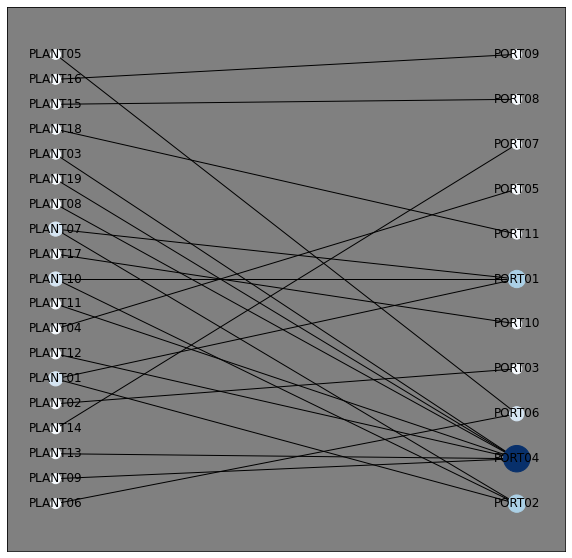

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor("Grey")

# specify layout for the graph
# layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant Code"])

layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

for i in layout:
    if i.startswith("PLANT"):
        layout[i][0] -= 0.1
    else:
        layout[i][0] += 0.1

# we want to map the degree of the node to a color/size
degrees = dict(plant_ports_graph.degree)
maps = [v*100 for v in degrees.values()]

# specify the color map
cmap = plt.cm.Blues

# keyword args that are the same for both functions
kwargs = {"pos":layout, "ax":ax}

nx.draw_networkx_nodes(plant_ports_graph, node_size=maps, node_color=maps, cmap=cmap, **kwargs)
nx.draw_networkx_edges(plant_ports_graph, **kwargs)
nx.draw_networkx_labels(plant_ports_graph, pos=layout)
plt.show()

In [14]:
# get starting and ending points of the edges and add them to the graph
layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

edge_x = []
edge_y = []

for edge in plant_ports_graph.edges():
    x0, y0 = layout[edge[0]]
    x1, y1 = layout[edge[1]]
    
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#25488e'),
    hoverinfo='none',
    mode='lines')

# get coordinated of nodes and add them to the graph

node_x = []
node_y = []
for node in plant_ports_graph.nodes():
    x, y = layout[node]
    node_x.append(x)
    node_y.append(y)
    
maps = [v for v in degrees.values()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=maps,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.text = [i + " Number of Links: " + str(degrees[i]) for i in degrees]

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Supply Chain',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(text="Factories",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.005, y=-0.002 ),
                             dict(text="Ports",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.95, y=-0.002 )],
                xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                )
fig

In [15]:
order_new = order_list.drop(columns=["Order_Date", "Origin_Port", "Carrier", "Plant_Code", "TPT", "Service_Level", "Ship_ahead_day_count", "Ship_Late_Day_count"])
order_new.set_index("Order_ID", inplace=True)
order_new.to_csv("order_new.csv")

In [16]:
freight_rates.drop(columns=["dest_port_cd", "Carrier type", "svc_cd"], inplace=True)
freight_rates.to_csv("FreightRates_mod.csv")

In [17]:
# given a product id, return the plants that can produce this product.
def product_restriction(index):
    data = order_new.loc[index]
    product_id = data["Product_ID"]
    possible_plants = products_plants.loc[products_plants["Product_ID"] == product_id]
    return np.array(possible_plants["Plant_Code"])

# vmi restriction: check if a given customer has to be serviced by a specific facility, else return all facilities as possibilities.
def customer_restriction(index):
    data = order_new.loc[index]
    Customer_id = data["Customer"]
    possible_plants = vmi_plants.loc[vmi_plants["Customers"] == Customer_id]
    if list(possible_plants["Plant_Code"]) == []:
        return plant_ports["Plant_Code"].unique()
    else:
        return np.array(possible_plants["Plant_Code"])

# combine both the product and vmi restriction. There will be orders for which only one, or possibly even 0, facilities can fullfil it.
def check_order(Order_Id, length=True):
    if length:
        return len(np.intersect1d(customer_restriction(Order_Id), product_restriction(Order_Id)))
    else:
        return np.intersect1d(customer_restriction(Order_Id), product_restriction(Order_Id))

# under the restrictions above, we can calculate the number of facilities that can process a given order.
order_new["decision_space_size"] = np.array(list(map(check_order, order_new.index)))

In [18]:
order_new["decision_space_size"].value_counts()

1    6275
0    1045
4     982
2     785
3     127
5       1
Name: decision_space_size, dtype: int64

In [19]:
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        # noinspection PyUnusedLocal
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]

In [20]:
class Ant:
    """
    Single Ant
    Create a single ant with its properties
    :param int size: the dimension or length of the ant
    """
    uid = 0
    def __init__(self, size):
        self.uid = self.__class__.uid
        self.__class__.uid += 1

        self.size = size
        self.tourLength = np.inf
        self.tour = np.ones(self.size, dtype=np.int64)*-1
        self.visited = np.zeros(self.size, dtype=np.int64)

    def clone(self):
        """
        Returns a deep copy of the current Ant instance with a new UID
        """
        ant = Ant(len(self.tour))
        ant.tourLength = self.tourLength
        ant.tour = self.tour.copy()
        ant.visited = self.visited.copy()
        return ant

In [21]:
class ACO:
 
    def __init__(self, cities, ants = -1, maxIter = 500, alpha = 1.0, beta = 2.0, rho = 0.5):
        self.cities = cities
        self.ants = ants
        self.maxIter = maxIter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.start = None
        self.initialize()

    def initialize(self):

        self.n = len(self.cities)
        self.iter = 0
        self.bestSoFarAnt = Ant(self.n)
        self.foundBest = 0
        self.restartBestAnt = Ant(self.n)
        self.restartFoundBest = 0
        self.colony = self.createColony(self.ants, self.n)
        self.pheromone = self.resetPheromone(self.ants)
        self.choiceInfo = self.computeChoiceInfo(self.pheromone)

    def computeTourLength(self,tour):

        return sum(distance(self.cities[tour[i]],self.cities[tour[i+1]]) for i in range(len(tour)-1))

    def createColony(self, numOfAnts, size):
        """Create a colony of ants according to the number of ants specified,"""
        colony = []
        for i in range(numOfAnts):
            colony.append(Ant(size))
        return np.array(colony)

    def resetPheromone(self, level=0.1):

        pheromone = np.ones((self.n, self.n), dtype=np.float) * level
        return pheromone

    def computeChoiceInfo(self, pheromone):

        return pheromone**self.alpha**self.beta

    def run(self):
        progress = []
        t0 = time.clock()

        while self.iter < self.maxIter:
            self.generateSolutions()
            self.updateStatistics()
            self.updatePheromone()
            self.iter += 1

            lenValues = np.array([ant.tourLength for ant in self.colony])
            progress.append(np.amin(lenValues))
            stats = [self.iter,np.amax(lenValues),np.amin(lenValues),np.mean(lenValues),np.std(lenValues)]
            
        t1 = time.clock()
       
        bestTour = [self.cities[i] for i in self.bestSoFarAnt.tour]
        return progress, bestTour

    def generateSolutions(self):

        step = 0

        for ant in self.colony:
            for i in range(len(ant.visited)):
                ant.visited[i] = 0

        for ant in self.colony:
            r = np.random.randint(0, self.n)
            ant.tour[step] = r
            ant.visited[r] = 1

        while step < self.n-1:
            step += 1
            for k in range(self.ants):
                self.decisionRule(k,step)

        for ant in self.colony:
            ant.tourLength = self.computeTourLength(ant.tour)

    def decisionRule(self, k, i):

        c = self.colony[k].tour[i-1] 
        sumProp = 0.0
        selectProb = np.zeros(self.n, dtype=np.float)
        for j in range(self.n):
            if self.colony[k].visited[j]:
                selectProb[j] = 0.0 
            else:

                selectProb[j] = self.choiceInfo[c][j]
                sumProp += selectProb[j]


        r = sumProp*np.random.random_sample()
        j = 0
        p = selectProb[j]
        while p < r:
            j += 1
            p += selectProb[j]

        self.colony[k].tour[i] = j
        self.colony[k].visited[j] = 1

    def updateStatistics(self):
        iterBestAnt = self.findBest()
       
        diff = self.bestSoFarAnt.tourLength - iterBestAnt.tourLength
        if diff > EPSILON:
            self.bestSoFarAnt = iterBestAnt.clone()
            self.restartBestAnt = iterBestAnt.clone()
            self.foundBest = self.iter
            self.restartFoundBest = self.iter

        
        diff = self.restartBestAnt.tourLength - iterBestAnt.tourLength
        if diff > EPSILON:
            self.restartBestAnt = iterBestAnt.clone()
            self.restartFoundBest = self.iter
   
    def updatePheromone(self):
      
        self.pheromone = self.pheromone*(1.0-self.rho)
        for ant in self.colony:

            delta = 1.0 / ant.tourLength
            for i in range(self.n-1):
                j = ant.tour[i]
                k = ant.tour[i+1]
                self.pheromone[j][k] = self.pheromone[j][k] + delta
                self.pheromone[k][j] = self.pheromone[j][k]

        self.choiceInfo = self.computeChoiceInfo(self.pheromone)

    def findBest(self):

        best = self.colony[0]
        for ant in self.colony:
            if ant.tourLength < best.tourLength:
                best = ant.clone()
        return best

In [22]:
def easom(variables_values = [0, 0]):
    x1, x2     = variables_values
    func_value = -np.cos(x1)*np.cos(x2)*np.exp(-(x1 - np.pi)**2 - (x2 - np.pi)**2)
    return func_value

parameters = {
    'swarm_size': 250,
    'min_values': (-5, -5),
    'max_values': (5, 5),
    'iterations': 100,
    'decay': 0,
    'w': 0.9,
    'c1': 2,
    'c2': 2
}

pso = particle_swarm_optimization(target_function = easom, **parameters)

variables = pso[:-1]
minimum   = pso[ -1]
print('Variables: ', np.around(variables, 4) , ' Minimum Value Found: ', round(minimum, 4) )

Iteration =  0  f(x) =  -0.8286483172995298
Iteration =  1  f(x) =  -0.8286483172995298
Iteration =  2  f(x) =  -0.8983815303041337
Iteration =  3  f(x) =  -0.9303579979815364
Iteration =  4  f(x) =  -0.9303579979815364
Iteration =  5  f(x) =  -0.9303579979815364
Iteration =  6  f(x) =  -0.9638269216070567
Iteration =  7  f(x) =  -0.9925890067736639
Iteration =  8  f(x) =  -0.9925890067736639
Iteration =  9  f(x) =  -0.9925890067736639
Iteration =  10  f(x) =  -0.9925890067736639
Iteration =  11  f(x) =  -0.9925890067736639
Iteration =  12  f(x) =  -0.9998127529333505
Iteration =  13  f(x) =  -0.9998127529333505
Iteration =  14  f(x) =  -0.9998891766913867
Iteration =  15  f(x) =  -0.9998891766913867
Iteration =  16  f(x) =  -0.9998891766913867
Iteration =  17  f(x) =  -0.9998891766913867
Iteration =  18  f(x) =  -0.9998891766913867
Iteration =  19  f(x) =  -0.9998891766913867
Iteration =  20  f(x) =  -0.9998891766913867
Iteration =  21  f(x) =  -0.9998891766913867
Iteration =  22  f(x



[iteration 0]: find a improved path, its distance is 1849.585703
it takes 0.466 second multiple_ant_colony_system running



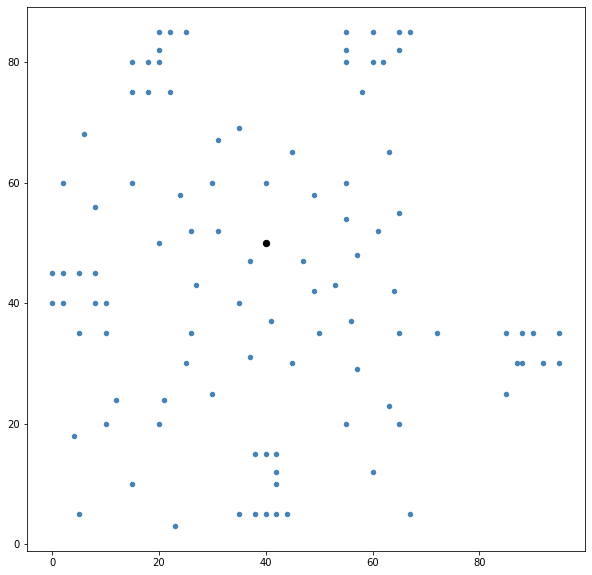


[iteration 1]: find a improved path, its distance is 1784.486614
it takes 0.716 second multiple_ant_colony_system running


[iteration 2]: find a improved path, its distance is 1720.793736
it takes 0.922 second multiple_ant_colony_system running


[iteration 3]: find a improved path, its distance is 1529.141333
it takes 1.101 second multiple_ant_colony_system running


[iteration 5]: find a improved path, its distance is 1463.885819
it takes 1.422 second multiple_ant_colony_system running


[iteration 7]: find a improved path, its distance is 1452.103729
it takes 1.722 second multiple_ant_colony_system running


[iteration 9]: find a improved path, its distance is 1360.571628
it takes 2.138 second multiple_ant_colony_system running


[iteration 11]: find a improved path, its distance is 1299.338885
it takes 2.547 second multiple_ant_colony_system running


[iteration 16]: find a improved path, its distance is 1221.786488
it takes 3.432 second multiple_ant_colony_system running


[iter

KeyboardInterrupt: ignored

In [23]:
class Node:
    def __init__(self, id:  int, x: float, y: float, demand: float, ready_time: float, due_time: float, service_time: float):
        super()
        self.id = id

        if id == 0:
            self.is_depot = True
        else:
            self.is_depot = False

        self.x = x
        self.y = y
        self.demand = demand
        self.ready_time = ready_time
        self.due_time = due_time
        self.service_time = service_time


class VrptwGraph:
    def __init__(self, file_path, rho=0.1):
        super()

        self.node_num, self.nodes, self.node_dist_mat, self.vehicle_num, self.vehicle_capacity \
            = self.create_from_file(file_path)

        self.rho = rho


        self.nnh_travel_path, self.init_pheromone_val, _ = self.nearest_neighbor_heuristic()
        self.init_pheromone_val = 1/(self.init_pheromone_val * self.node_num)

        self.pheromone_mat = np.ones((self.node_num, self.node_num)) * self.init_pheromone_val

        self.heuristic_info_mat = 1 / self.node_dist_mat

    def copy(self, init_pheromone_val):
        new_graph = copy.deepcopy(self)


        new_graph.init_pheromone_val = init_pheromone_val
        new_graph.pheromone_mat = np.ones((new_graph.node_num, new_graph.node_num)) * init_pheromone_val

        return new_graph

    def create_from_file(self, file_path):

        node_list = []
        with open(file_path, 'rt') as f:
            count = 1
            for line in f:
                if count == 5:
                    vehicle_num, vehicle_capacity = line.split()
                    vehicle_num = int(vehicle_num)
                    vehicle_capacity = int(vehicle_capacity)
                elif count >= 10:
                    node_list.append(line.split())
                count += 1
        node_num = len(node_list)
        nodes = list(Node(int(item[0]), float(item[1]), float(item[2]), float(item[3]), float(item[4]), float(item[5]), float(item[6])) for item in node_list)


        node_dist_mat = np.zeros((node_num, node_num))
        for i in range(node_num):
            node_a = nodes[i]
            node_dist_mat[i][i] = 1e-8
            for j in range(i+1, node_num):
                node_b = nodes[j]
                node_dist_mat[i][j] = VrptwGraph.calculate_dist(node_a, node_b)
                node_dist_mat[j][i] = node_dist_mat[i][j]

        return node_num, nodes, node_dist_mat, vehicle_num, vehicle_capacity

    @staticmethod
    def calculate_dist(node_a, node_b):
        return np.linalg.norm((node_a.x - node_b.x, node_a.y - node_b.y))

    def local_update_pheromone(self, start_ind, end_ind):
        self.pheromone_mat[start_ind][end_ind] = (1-self.rho) * self.pheromone_mat[start_ind][end_ind] + \
                                                  self.rho * self.init_pheromone_val

    def global_update_pheromone(self, best_path, best_path_distance):

        self.pheromone_mat = (1-self.rho) * self.pheromone_mat

        current_ind = best_path[0]
        for next_ind in best_path[1:]:
            self.pheromone_mat[current_ind][next_ind] += self.rho/best_path_distance
            current_ind = next_ind

    def nearest_neighbor_heuristic(self, max_vehicle_num=None):
        index_to_visit = list(range(1, self.node_num))
        current_index = 0
        current_load = 0
        current_time = 0
        travel_distance = 0
        travel_path = [0]

        if max_vehicle_num is None:
            max_vehicle_num = self.node_num

        while len(index_to_visit) > 0 and max_vehicle_num > 0:
            nearest_next_index = self._cal_nearest_next_index(index_to_visit, current_index, current_load, current_time)

            if nearest_next_index is None:
                travel_distance += self.node_dist_mat[current_index][0]

                current_load = 0
                current_time = 0
                travel_path.append(0)
                current_index = 0

                max_vehicle_num -= 1
            else:
                current_load += self.nodes[nearest_next_index].demand

                dist = self.node_dist_mat[current_index][nearest_next_index]
                wait_time = max(self.nodes[nearest_next_index].ready_time - current_time - dist, 0)
                service_time = self.nodes[nearest_next_index].service_time

                current_time += dist + wait_time + service_time
                index_to_visit.remove(nearest_next_index)

                travel_distance += self.node_dist_mat[current_index][nearest_next_index]
                travel_path.append(nearest_next_index)
                current_index = nearest_next_index

        travel_distance += self.node_dist_mat[current_index][0]
        travel_path.append(0)

        vehicle_num = travel_path.count(0)-1
        return travel_path, travel_distance, vehicle_num

    def _cal_nearest_next_index(self, index_to_visit, current_index, current_load, current_time):

        nearest_ind = None
        nearest_distance = None

        for next_index in index_to_visit:
            if current_load + self.nodes[next_index].demand > self.vehicle_capacity:
                continue

            dist = self.node_dist_mat[current_index][next_index]
            wait_time = max(self.nodes[next_index].ready_time - current_time - dist, 0)
            service_time = self.nodes[next_index].service_time

            if current_time + dist + wait_time + service_time + self.node_dist_mat[next_index][0] > self.nodes[0].due_time:
                continue


            if current_time + dist > self.nodes[next_index].due_time:
                continue

            if nearest_distance is None or self.node_dist_mat[current_index][next_index] < nearest_distance:
                nearest_distance = self.node_dist_mat[current_index][next_index]
                nearest_ind = next_index

        return nearest_ind


class PathMessage:
    def __init__(self, path, distance):
        if path is not None:
            self.path = copy.deepcopy(path)
            self.distance = copy.deepcopy(distance)
            self.used_vehicle_num = self.path.count(0) - 1
        else:
            self.path = None
            self.distance = None
            self.used_vehicle_num = None

    def get_path_info(self):
        return self.path, self.distance, self.used_vehicle_num

class VrptwAcoFigure:
    def __init__(self, nodes: list, path_queue: MPQueue):

        self.nodes = nodes
        self.figure = plt.figure(figsize=(10, 10))
        self.figure_ax = self.figure.add_subplot(1, 1, 1)
        self.path_queue = path_queue
        self._depot_color = 'k'
        self._customer_color = 'steelblue'
        self._line_color = 'darksalmon'

    def _draw_point(self):

        self.figure_ax.scatter([self.nodes[0].x], [self.nodes[0].y], c=self._depot_color, label='depot', s=40)


        self.figure_ax.scatter(list(node.x for node in self.nodes[1:]),
                               list(node.y for node in self.nodes[1:]), c=self._customer_color, label='customer', s=20)
        plt.pause(0.5)

    def run(self):

        self._draw_point()
        self.figure.show()


        while True:
            if not self.path_queue.empty():

                info = self.path_queue.get()
                while not self.path_queue.empty():
                    info = self.path_queue.get()

                path, distance, used_vehicle_num = info.get_path_info()
                if path is None:
                    print('[draw figure]: exit')
                    break


                remove_obj = []
                for line in self.figure_ax.lines:
                    if line._label == 'line':
                        remove_obj.append(line)

                for line in remove_obj:
                    self.figure_ax.lines.remove(line)
                remove_obj.clear()


                self.figure_ax.set_title('travel distance: %0.2f, number of vehicles: %d ' % (distance, used_vehicle_num))
                self._draw_line(path)
            plt.pause(1)

    def _draw_line(self, path):

        for i in range(1, len(path)):
            x_list = [self.nodes[path[i - 1]].x, self.nodes[path[i]].x]
            y_list = [self.nodes[path[i - 1]].y, self.nodes[path[i]].y]
            self.figure_ax.plot(x_list, y_list, color=self._line_color, linewidth=1.5, label='line')
            plt.pause(0.2)

class Ant:
    def __init__(self, graph: VrptwGraph, start_index=0):
        super()
        self.graph = graph
        self.current_index = start_index
        self.vehicle_load = 0
        self.vehicle_travel_time = 0
        self.travel_path = [start_index]
        self.arrival_time = [0]

        self.index_to_visit = list(range(graph.node_num))
        self.index_to_visit.remove(start_index)

        self.total_travel_distance = 0

    def clear(self):
        self.travel_path.clear()
        self.index_to_visit.clear()

    def move_to_next_index(self, next_index):

        self.travel_path.append(next_index)
        self.total_travel_distance += self.graph.node_dist_mat[self.current_index][next_index]

        dist = self.graph.node_dist_mat[self.current_index][next_index]
        self.arrival_time.append(self.vehicle_travel_time + dist)

        if self.graph.nodes[next_index].is_depot:

            self.vehicle_load = 0
            self.vehicle_travel_time = 0

        else:

            self.vehicle_load += self.graph.nodes[next_index].demand


            self.vehicle_travel_time += dist + max(self.graph.nodes[next_index].ready_time - self.vehicle_travel_time - dist, 0) + self.graph.nodes[next_index].service_time
            self.index_to_visit.remove(next_index)

        self.current_index = next_index

    def index_to_visit_empty(self):
        return len(self.index_to_visit) == 0

    def get_active_vehicles_num(self):
        return self.travel_path.count(0)-1

    def check_condition(self, next_index) -> bool:

        if self.vehicle_load + self.graph.nodes[next_index].demand > self.graph.vehicle_capacity:
            return False

        dist = self.graph.node_dist_mat[self.current_index][next_index]
        wait_time = max(self.graph.nodes[next_index].ready_time - self.vehicle_travel_time - dist, 0)
        service_time = self.graph.nodes[next_index].service_time


        if self.vehicle_travel_time + dist + wait_time + service_time + self.graph.node_dist_mat[next_index][0] > self.graph.nodes[0].due_time:
            return False


        if self.vehicle_travel_time + dist > self.graph.nodes[next_index].due_time:
            return False

        return True

    def cal_next_index_meet_constrains(self):

        next_index_meet_constrains = []
        for next_ind in self.index_to_visit:
            if self.check_condition(next_ind):
                next_index_meet_constrains.append(next_ind)
        return next_index_meet_constrains

    def cal_nearest_next_index(self, next_index_list):

        current_ind = self.current_index

        nearest_ind = next_index_list[0]
        min_dist = self.graph.node_dist_mat[current_ind][next_index_list[0]]

        for next_ind in next_index_list[1:]:
            dist = self.graph.node_dist_mat[current_ind][next_ind]
            if dist < min_dist:
                min_dist = dist
                nearest_ind = next_ind

        return nearest_ind

    @staticmethod
    def cal_total_travel_distance(graph: VrptwGraph, travel_path):
        distance = 0
        current_ind = travel_path[0]
        for next_ind in travel_path[1:]:
            distance += graph.node_dist_mat[current_ind][next_ind]
            current_ind = next_ind
        return distance

    def try_insert_on_path(self, node_id, stop_event: Event):

        best_insert_index = None
        best_distance = None

        for insert_index in range(len(self.travel_path)):

            if stop_event.is_set():

                return

            if self.graph.nodes[self.travel_path[insert_index]].is_depot:
                continue


            front_depot_index = insert_index
            while front_depot_index >= 0 and not self.graph.nodes[self.travel_path[front_depot_index]].is_depot:
                front_depot_index -= 1
            front_depot_index = max(front_depot_index, 0)


            check_ant = Ant(self.graph, self.travel_path[front_depot_index])


            for i in range(front_depot_index+1, insert_index):
                check_ant.move_to_next_index(self.travel_path[i])


            if check_ant.check_condition(node_id):
                check_ant.move_to_next_index(node_id)
            else:
                continue


            for next_ind in self.travel_path[insert_index:]:

                if stop_event.is_set():

                    return

                if check_ant.check_condition(next_ind):
                    check_ant.move_to_next_index(next_ind)


                    if self.graph.nodes[next_ind].is_depot:
                        temp_front_index = self.travel_path[insert_index-1]
                        temp_back_index = self.travel_path[insert_index]

                        check_ant_distance = self.total_travel_distance - self.graph.node_dist_mat[temp_front_index][temp_back_index] + \
                                             self.graph.node_dist_mat[temp_front_index][node_id] + self.graph.node_dist_mat[node_id][temp_back_index]

                        if best_distance is None or check_ant_distance < best_distance:
                            best_distance = check_ant_distance
                            best_insert_index = insert_index
                        break


                else:
                    break

        return best_insert_index

    def insertion_procedure(self, stop_even: Event):

        if self.index_to_visit_empty():
            return

        success_to_insert = True

        while success_to_insert:

            success_to_insert = False

            ind_to_visit = np.array(copy.deepcopy(self.index_to_visit))


            demand = np.zeros(len(ind_to_visit))
            for i, ind in zip(range(len(ind_to_visit)), ind_to_visit):
                demand[i] = self.graph.nodes[ind].demand

            arg_ind = np.argsort(demand)[::-1]
            ind_to_visit = ind_to_visit[arg_ind]

            for node_id in ind_to_visit:
                if stop_even.is_set():

                    return

                best_insert_index = self.try_insert_on_path(node_id, stop_even)
                if best_insert_index is not None:
                    self.travel_path.insert(best_insert_index, node_id)
                    self.index_to_visit.remove(node_id)

                    success_to_insert = True

            del demand
            del ind_to_visit
        if self.index_to_visit_empty():
            print('[insertion_procedure]: success in insertion')

        self.total_travel_distance = Ant.cal_total_travel_distance(self.graph, self.travel_path)

    @staticmethod
    def local_search_once(graph: VrptwGraph, travel_path: list, travel_distance: float, i_start, stop_event: Event):


        depot_ind = []
        for ind in range(len(travel_path)):
            if graph.nodes[travel_path[ind]].is_depot:
                depot_ind.append(ind)


        for i in range(i_start, len(depot_ind)):
            for j in range(i + 1, len(depot_ind)):

                if stop_event.is_set():
                    return None, None, None

                for start_a in range(depot_ind[i - 1] + 1, depot_ind[i]):
                    for end_a in range(start_a, min(depot_ind[i], start_a + 6)):
                        for start_b in range(depot_ind[j - 1] + 1, depot_ind[j]):
                            for end_b in range(start_b, min(depot_ind[j], start_b + 6)):
                                if start_a == end_a and start_b == end_b:
                                    continue
                                new_path = []
                                new_path.extend(travel_path[:start_a])
                                new_path.extend(travel_path[start_b:end_b + 1])
                                new_path.extend(travel_path[end_a:start_b])
                                new_path.extend(travel_path[start_a:end_a])
                                new_path.extend(travel_path[end_b + 1:])

                                depot_before_start_a = depot_ind[i - 1]

                                depot_before_start_b = depot_ind[j - 1] + (end_b - start_b) - (end_a - start_a) + 1
                                if not graph.nodes[new_path[depot_before_start_b]].is_depot:
                                    raise RuntimeError('error')


                                success_route_a = False
                                check_ant = Ant(graph, new_path[depot_before_start_a])
                                for ind in new_path[depot_before_start_a + 1:]:
                                    if check_ant.check_condition(ind):
                                        check_ant.move_to_next_index(ind)
                                        if graph.nodes[ind].is_depot:
                                            success_route_a = True
                                            break
                                    else:
                                        break

                                check_ant.clear()
                                del check_ant


                                success_route_b = False
                                check_ant = Ant(graph, new_path[depot_before_start_b])
                                for ind in new_path[depot_before_start_b + 1:]:
                                    if check_ant.check_condition(ind):
                                        check_ant.move_to_next_index(ind)
                                        if graph.nodes[ind].is_depot:
                                            success_route_b = True
                                            break
                                    else:
                                        break
                                check_ant.clear()
                                del check_ant

                                if success_route_a and success_route_b:
                                    new_path_distance = Ant.cal_total_travel_distance(graph, new_path)
                                    if new_path_distance < travel_distance:

                                        for temp_ind in range(1, len(new_path)):
                                            if graph.nodes[new_path[temp_ind]].is_depot and graph.nodes[new_path[temp_ind - 1]].is_depot:
                                                new_path.pop(temp_ind)
                                                break
                                        return new_path, new_path_distance, i
                                else:
                                    new_path.clear()

        return None, None, None

    def local_search_procedure(self, stop_event: Event):

        new_path = copy.deepcopy(self.travel_path)
        new_path_distance = self.total_travel_distance
        times = 100
        count = 0
        i_start = 1
        while count < times:
            temp_path, temp_distance, temp_i = Ant.local_search_once(self.graph, new_path, new_path_distance, i_start, stop_event)
            if temp_path is not None:
                count += 1

                del new_path, new_path_distance
                new_path = temp_path
                new_path_distance = temp_distance

                # 设置i_start
                i_start = (i_start + 1) % (new_path.count(0)-1)
                i_start = max(i_start, 1)
            else:
                break

        self.travel_path = new_path
        self.total_travel_distance = new_path_distance
        print('[local_search_procedure]: local search finished')

class BasicACO:
    def __init__(self, graph: VrptwGraph, ants_num=10, max_iter=200, beta=2, q0=0.1,
                 whether_or_not_to_show_figure=True):
        super()

        self.graph = graph

        self.ants_num = ants_num

        self.max_iter = max_iter

        self.max_load = graph.vehicle_capacity

        self.beta = beta

        self.q0 = q0

        self.best_path_distance = None
        self.best_path = None
        self.best_vehicle_num = None

        self.whether_or_not_to_show_figure = whether_or_not_to_show_figure

    def run_basic_aco(self):

        path_queue_for_figure = Queue()
        basic_aco_thread = Thread(target=self._basic_aco, args=(path_queue_for_figure,))
        basic_aco_thread.start()


        if self.whether_or_not_to_show_figure:
            figure = VrptwAcoFigure(self.graph.nodes, path_queue_for_figure)
            figure.run()
        basic_aco_thread.join()


        if self.whether_or_not_to_show_figure:
            path_queue_for_figure.put(PathMessage(None, None))

    def _basic_aco(self, path_queue_for_figure: Queue):

        start_time_total = time.time()


        start_iteration = 0
        for iter in range(self.max_iter):


            ants = list(Ant(self.graph) for _ in range(self.ants_num))
            for k in range(self.ants_num):


                while not ants[k].index_to_visit_empty():
                    next_index = self.select_next_index(ants[k])

                    if not ants[k].check_condition(next_index):
                        next_index = self.select_next_index(ants[k])
                        if not ants[k].check_condition(next_index):
                            next_index = 0


                    ants[k].move_to_next_index(next_index)
                    self.graph.local_update_pheromone(ants[k].current_index, next_index)


                ants[k].move_to_next_index(0)
                self.graph.local_update_pheromone(ants[k].current_index, 0)

            paths_distance = np.array([ant.total_travel_distance for ant in ants])

            best_index = np.argmin(paths_distance)
            if self.best_path is None or paths_distance[best_index] < self.best_path_distance:
                self.best_path = ants[int(best_index)].travel_path
                self.best_path_distance = paths_distance[best_index]
                self.best_vehicle_num = self.best_path.count(0) - 1
                start_iteration = iter


                if self.whether_or_not_to_show_figure:
                    path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))

                print('\n')
                print('[iteration %d]: find a improved path, its distance is %f' % (iter, self.best_path_distance))
                print('it takes %0.3f second multiple_ant_colony_system running' % (time.time() - start_time_total))


            self.graph.global_update_pheromone(self.best_path, self.best_path_distance)

            given_iteration = 100
            if iter - start_iteration > given_iteration:
                print('\n')
                print('iteration exit: can not find better solution in %d iteration' % given_iteration)
                break

        print('\n')
        print('final best path distance is %f, number of vehicle is %d' % (self.best_path_distance, self.best_vehicle_num))
        print('it takes %0.3f second multiple_ant_colony_system running' % (time.time() - start_time_total))

    def select_next_index(self, ant):

        current_index = ant.current_index
        index_to_visit = ant.index_to_visit

        transition_prob = self.graph.pheromone_mat[current_index][index_to_visit] * \
            np.power(self.graph.heuristic_info_mat[current_index][index_to_visit], self.beta)
        transition_prob = transition_prob / np.sum(transition_prob)

        if np.random.rand() < self.q0:
            max_prob_index = np.argmax(transition_prob)
            next_index = index_to_visit[max_prob_index]
        else:

            next_index = BasicACO.stochastic_accept(index_to_visit, transition_prob)
        return next_index

    @staticmethod
    def stochastic_accept(index_to_visit, transition_prob):

        N = len(index_to_visit)

     
        sum_tran_prob = np.sum(transition_prob)
        norm_transition_prob = transition_prob/sum_tran_prob


        while True:

            ind = int(N * random.random())
            if random.random() <= norm_transition_prob[ind]:
                return index_to_visit[ind]


class MultipleAntColonySystem:
    def __init__(self, graph: VrptwGraph, ants_num=10, beta=1, q0=0.1, whether_or_not_to_show_figure=True):
        super()

        self.graph = graph

        self.ants_num = ants_num

        self.max_load = graph.vehicle_capacity

        self.beta = beta

        self.q0 = q0

        self.best_path_distance = None
        self.best_path = None
        self.best_vehicle_num = None

        self.whether_or_not_to_show_figure = whether_or_not_to_show_figure

    @staticmethod
    def stochastic_accept(index_to_visit, transition_prob):

        N = len(index_to_visit)


        sum_tran_prob = np.sum(transition_prob)
        norm_transition_prob = transition_prob/sum_tran_prob

        while True:

            ind = int(N * random.random())
            if random.random() <= norm_transition_prob[ind]:
                return index_to_visit[ind]

    @staticmethod
    def new_active_ant(ant: Ant, vehicle_num: int, local_search: bool, IN: np.numarray, q0: float, beta: int, stop_event: Event):

        unused_depot_count = vehicle_num


        while not ant.index_to_visit_empty() and unused_depot_count > 0:
            if stop_event.is_set():

                return


            next_index_meet_constrains = ant.cal_next_index_meet_constrains()


            if len(next_index_meet_constrains) == 0:
                ant.move_to_next_index(0)
                unused_depot_count -= 1
                continue


            length = len(next_index_meet_constrains)
            ready_time = np.zeros(length)
            due_time = np.zeros(length)

            for i in range(length):
                ready_time[i] = ant.graph.nodes[next_index_meet_constrains[i]].ready_time
                due_time[i] = ant.graph.nodes[next_index_meet_constrains[i]].due_time

            delivery_time = np.maximum(ant.vehicle_travel_time + ant.graph.node_dist_mat[ant.current_index][next_index_meet_constrains], ready_time)
            delta_time = delivery_time - ant.vehicle_travel_time
            distance = delta_time * (due_time - ant.vehicle_travel_time)

            distance = np.maximum(1.0, distance-IN[next_index_meet_constrains])
            closeness = 1/distance

            transition_prob = ant.graph.pheromone_mat[ant.current_index][next_index_meet_constrains] * \
                              np.power(closeness, beta)
            transition_prob = transition_prob / np.sum(transition_prob)


            if np.random.rand() < q0:
                max_prob_index = np.argmax(transition_prob)
                next_index = next_index_meet_constrains[max_prob_index]
            else:

                next_index = MultipleAntColonySystem.stochastic_accept(next_index_meet_constrains, transition_prob)


            ant.graph.local_update_pheromone(ant.current_index, next_index)
            ant.move_to_next_index(next_index)


        if ant.index_to_visit_empty():
            ant.graph.local_update_pheromone(ant.current_index, 0)
            ant.move_to_next_index(0)


        ant.insertion_procedure(stop_event)

        if local_search is True and ant.index_to_visit_empty():
            ant.local_search_procedure(stop_event)

    @staticmethod
    def acs_time(new_graph: VrptwGraph, vehicle_num: int, ants_num: int, q0: float, beta: int,
                 global_path_queue: Queue, path_found_queue: Queue, stop_event: Event):

        print('[acs_time]: start, vehicle_num %d' % vehicle_num)

        global_best_path = None
        global_best_distance = None
        ants_pool = ThreadPoolExecutor(ants_num)
        ants_thread = []
        ants = []
        while True:
            print('[acs_time]: new iteration')

            if stop_event.is_set():
                print('[acs_time]: receive stop event')
                return

            for k in range(ants_num):
                ant = Ant(new_graph, 0)
                thread = ants_pool.submit(MultipleAntColonySystem.new_active_ant, ant, vehicle_num, True,
                                          np.zeros(new_graph.node_num), q0, beta, stop_event)
                ants_thread.append(thread)
                ants.append(ant)


            for thread in ants_thread:
                thread.result()

            ant_best_travel_distance = None
            ant_best_path = None

            for ant in ants:

                if stop_event.is_set():
                    print('[acs_time]: receive stop event')
                    return

                if not global_path_queue.empty():
                    info = global_path_queue.get()
                    while not global_path_queue.empty():
                        info = global_path_queue.get()
                    print('[acs_time]: receive global path info')
                    global_best_path, global_best_distance, global_used_vehicle_num = info.get_path_info()


                if ant.index_to_visit_empty() and (ant_best_travel_distance is None or ant.total_travel_distance < ant_best_travel_distance):
                    ant_best_travel_distance = ant.total_travel_distance
                    ant_best_path = ant.travel_path


            new_graph.global_update_pheromone(global_best_path, global_best_distance)


            if ant_best_travel_distance is not None and ant_best_travel_distance < global_best_distance:
                print('[acs_time]: ants\' local search found a improved feasible path, send path info to macs')
                path_found_queue.put(PathMessage(ant_best_path, ant_best_travel_distance))

            ants_thread.clear()
            for ant in ants:
                ant.clear()
                del ant
            ants.clear()

    @staticmethod
    def acs_vehicle(new_graph: VrptwGraph, vehicle_num: int, ants_num: int, q0: float, beta: int,
                    global_path_queue: Queue, path_found_queue: Queue, stop_event: Event):


        print('[acs_vehicle]: start, vehicle_num %d' % vehicle_num)
        global_best_path = None
        global_best_distance = None

        current_path, current_path_distance, _ = new_graph.nearest_neighbor_heuristic(max_vehicle_num=vehicle_num)

        current_index_to_visit = list(range(new_graph.node_num))
        for ind in set(current_path):
            current_index_to_visit.remove(ind)

        ants_pool = ThreadPoolExecutor(ants_num)
        ants_thread = []
        ants = []
        IN = np.zeros(new_graph.node_num)
        while True:
            print('[acs_vehicle]: new iteration')

            if stop_event.is_set():
                print('[acs_vehicle]: receive stop event')
                return

            for k in range(ants_num):
                ant = Ant(new_graph, 0)
                thread = ants_pool.submit(MultipleAntColonySystem.new_active_ant, ant, vehicle_num, False, IN, q0,
                                          beta, stop_event)

                ants_thread.append(thread)
                ants.append(ant)

            for thread in ants_thread:
                thread.result()

            for ant in ants:

                if stop_event.is_set():
                    print('[acs_vehicle]: receive stop event')
                    return

                IN[ant.index_to_visit] = IN[ant.index_to_visit]+1

                if len(ant.index_to_visit) < len(current_index_to_visit):
                    current_path = copy.deepcopy(ant.travel_path)
                    current_index_to_visit = copy.deepcopy(ant.index_to_visit)
                    current_path_distance = ant.total_travel_distance

                    IN = np.zeros(new_graph.node_num)

                    if ant.index_to_visit_empty():
                        print('[acs_vehicle]: found a feasible path, send path info to macs')
                        path_found_queue.put(PathMessage(ant.travel_path, ant.total_travel_distance))


            new_graph.global_update_pheromone(current_path, current_path_distance)

            if not global_path_queue.empty():
                info = global_path_queue.get()
                while not global_path_queue.empty():
                    info = global_path_queue.get()
                print('[acs_vehicle]: receive global path info')
                global_best_path, global_best_distance, global_used_vehicle_num = info.get_path_info()

            new_graph.global_update_pheromone(global_best_path, global_best_distance)

            ants_thread.clear()
            for ant in ants:
                ant.clear()
                del ant
            ants.clear()

    def run_multiple_ant_colony_system(self, file_to_write_path=None):

        path_queue_for_figure = MPQueue()
        multiple_ant_colony_system_thread = Process(target=self._multiple_ant_colony_system, args=(path_queue_for_figure, file_to_write_path, ))
        multiple_ant_colony_system_thread.start()


        if self.whether_or_not_to_show_figure:
            figure = VrptwAcoFigure(self.graph.nodes, path_queue_for_figure)
            figure.run()
        multiple_ant_colony_system_thread.join()

    def _multiple_ant_colony_system(self, path_queue_for_figure: MPQueue, file_to_write_path=None):

        if file_to_write_path is not None:
            file_to_write = open(file_to_write_path, 'w')
        else:
            file_to_write = None

        start_time_total = time.time()

        global_path_to_acs_time = Queue()
        global_path_to_acs_vehicle = Queue()


        path_found_queue = Queue()


        self.best_path, self.best_path_distance, self.best_vehicle_num = self.graph.nearest_neighbor_heuristic()
        path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))

        while True:
            print('[multiple_ant_colony_system]: new iteration')
            start_time_found_improved_solution = time.time()


            global_path_to_acs_vehicle.put(PathMessage(self.best_path, self.best_path_distance))
            global_path_to_acs_time.put(PathMessage(self.best_path, self.best_path_distance))

            stop_event = Event()

            graph_for_acs_vehicle = self.graph.copy(self.graph.init_pheromone_val)
            acs_vehicle_thread = Thread(target=MultipleAntColonySystem.acs_vehicle,
                                        args=(graph_for_acs_vehicle, self.best_vehicle_num-1, self.ants_num, self.q0,
                                              self.beta, global_path_to_acs_vehicle, path_found_queue, stop_event))


            graph_for_acs_time = self.graph.copy(self.graph.init_pheromone_val)
            acs_time_thread = Thread(target=MultipleAntColonySystem.acs_time,
                                     args=(graph_for_acs_time, self.best_vehicle_num, self.ants_num, self.q0, self.beta,
                                           global_path_to_acs_time, path_found_queue, stop_event))


            print('[macs]: start acs_vehicle and acs_time')
            acs_vehicle_thread.start()
            acs_time_thread.start()

            best_vehicle_num = self.best_vehicle_num

            while acs_vehicle_thread.is_alive() and acs_time_thread.is_alive():

                given_time = 10
                if time.time() - start_time_found_improved_solution > 60 * given_time:
                    stop_event.set()
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    self.print_and_write_in_file(file_to_write, 'time is up: cannot find a better solution in given time(%d minutes)' % given_time)
                    self.print_and_write_in_file(file_to_write, 'it takes %0.3f second from multiple_ant_colony_system running' % (time.time()-start_time_total))
                    self.print_and_write_in_file(file_to_write, 'the best path have found is:')
                    self.print_and_write_in_file(file_to_write, self.best_path)
                    self.print_and_write_in_file(file_to_write, 'best path distance is %f, best vehicle_num is %d' % (self.best_path_distance, self.best_vehicle_num))
                    self.print_and_write_in_file(file_to_write, '*' * 50)

                    if self.whether_or_not_to_show_figure:
                        path_queue_for_figure.put(PathMessage(None, None))

                    if file_to_write is not None:
                        file_to_write.flush()
                        file_to_write.close()
                    return

                if path_found_queue.empty():
                    continue

                path_info = path_found_queue.get()
                print('[macs]: receive found path info')
                found_path, found_path_distance, found_path_used_vehicle_num = path_info.get_path_info()
                while not path_found_queue.empty():
                    path, distance, vehicle_num = path_found_queue.get().get_path_info()

                    if distance < found_path_distance:
                        found_path, found_path_distance, found_path_used_vehicle_num = path, distance, vehicle_num

                    if vehicle_num < found_path_used_vehicle_num:
                        found_path, found_path_distance, found_path_used_vehicle_num = path, distance, vehicle_num


                if found_path_distance < self.best_path_distance:

                    start_time_found_improved_solution = time.time()

                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    self.print_and_write_in_file(file_to_write, '[macs]: distance of found path (%f) better than best path\'s (%f)' % (found_path_distance, self.best_path_distance))
                    self.print_and_write_in_file(file_to_write, 'it takes %0.3f second from multiple_ant_colony_system running' % (time.time()-start_time_total))
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    if file_to_write is not None:
                        file_to_write.flush()

                    self.best_path = found_path
                    self.best_vehicle_num = found_path_used_vehicle_num
                    self.best_path_distance = found_path_distance


                    if self.whether_or_not_to_show_figure:
                        path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))


                    global_path_to_acs_vehicle.put(PathMessage(self.best_path, self.best_path_distance))
                    global_path_to_acs_time.put(PathMessage(self.best_path, self.best_path_distance))


                if found_path_used_vehicle_num < best_vehicle_num:


                    start_time_found_improved_solution = time.time()
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    self.print_and_write_in_file(file_to_write, '[macs]: vehicle num of found path (%d) better than best path\'s (%d), found path distance is %f'
                          % (found_path_used_vehicle_num, best_vehicle_num, found_path_distance))
                    self.print_and_write_in_file(file_to_write, 'it takes %0.3f second multiple_ant_colony_system running' % (time.time() - start_time_total))
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    if file_to_write is not None:
                        file_to_write.flush()

                    self.best_path = found_path
                    self.best_vehicle_num = found_path_used_vehicle_num
                    self.best_path_distance = found_path_distance

                    if self.whether_or_not_to_show_figure:
                        path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))

                    print('[macs]: send stop info to acs_time and acs_vehicle')

                    stop_event.set()

    @staticmethod
    def print_and_write_in_file(file_to_write=None, message='default message'):
        if file_to_write is None:
            print(message)
        else:
            print(message)
            file_to_write.write(str(message)+'\n')

if __name__ == '__main__':
    file_path = '/content/drive/MyDrive/Bachelor Project/input.txt'
    ants_num = 10
    max_iter = 100
    beta = 2
    q0 = 0.1
    show_figure = True

    graph = VrptwGraph(file_path)
    basic_aco = BasicACO(graph, ants_num=ants_num, max_iter=max_iter, beta=beta, q0=q0,
                         whether_or_not_to_show_figure=show_figure)

    basic_aco.run_basic_aco()

In [24]:
freight_rates["rate"].describe()

count    1537.000000
mean        2.875135
std         4.590475
min         0.033200
25%         0.451200
50%         1.656800
75%         3.916800
max       128.027200
Name: rate, dtype: float64

In [25]:
ports_agg = freight_rates.groupby(["orig_port_cd"]).agg(avg_rate=("rate", np.mean))
# we will exclude orders that cannot be processed by any facility (i.e. where the decision space size == 0)
order_new = order_new.loc[order_new.decision_space_size != 0]
# return the possible plants that can process the order.
order_new["decision_space_plants"] = np.array((map(lambda x: check_order(x, length=False), order_new.index)))

def min_cost(dec_space):
    
    plant_port_cost = {}
    
    wh = wh_cost.copy()
    min_cost = np.inf
    
    for plant in dec_space:
        plant_port_cost[plant] = wh.loc[plant].iloc[0]
        port_price, port = find_best_port(plant)
        plant_port_cost[plant] += port_price
        
        if plant_port_cost[plant] < min_cost:
            min_cost = plant_port_cost[plant]
            best_plant = plant
            best_port = port
            best_port_price = port_price
        
    return min_cost, best_plant, best_port_price, best_port

# given a port and the order specifications return the carrier that can handle the product at the best price.
def find_best_port(plant_id):
    # choose the ports that have a connection to the given plant and then find the port with the lowest freight rate
    possible_ports = plant_ports.loc[(plant_ports.Plant_Code == plant_id) & (plant_ports.Port != "PORT01"), "Port"]
    possible_ports = ports_agg.loc[possible_ports]
    return possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0]["avg_rate"], possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0].name

order_new["decision"] = order_new["decision_space_plants"].apply(min_cost)

In [26]:
order_new["decision"]

Order_ID
1.447296e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447158e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447139e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
                                      ...                        
1.447372e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447372e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447328e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447358e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447287e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
Name: decision, Length: 8170, dtype: object

In [27]:
decision = order_new["decision"].tolist()
lenn = len(decision)
min_cost_list = []
for i in range(lenn):
  min_cost_list.append(decision[i][0])
best_plant_list = []
for i in range(lenn):
  best_plant_list.append(decision[i][1])
best_port_price_list = []
for i in range(lenn):
  best_port_price_list.append(decision[i][2])
best_port_list = []
for i in range(lenn):
  best_port_list.append(decision[i][3])

decision_dataframe = pd.DataFrame(
    {'min_cost': min_cost_list,
     'best_plant': best_plant_list,
     'best_port_price': best_port_price_list,
     'best_port': best_port_list,
    })

In [34]:
decision_dataframe

,min_cost,best_plant,best_port_price,best_port
0,4.756374,PLANT16,2.836567,PORT09
1,4.756374,PLANT16,2.836567,PORT09
2,4.756374,PLANT16,2.836567,PORT09
3,4.756374,PLANT16,2.836567,PORT09
4,4.756374,PLANT16,2.836567,PORT09
...,...,...,...,...
8165,10.321904,PLANT02,9.844400,PORT03
8166,10.321904,PLANT02,9.844400,PORT03
8167,10.321904,PLANT02,9.844400,PORT03
8168,10.321904,PLANT02,9.844400,PORT03


In [33]:
path = '/content/drive/MyDrive/Bachelor Project/output.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  decision_dataframe.to_csv('output.csv')

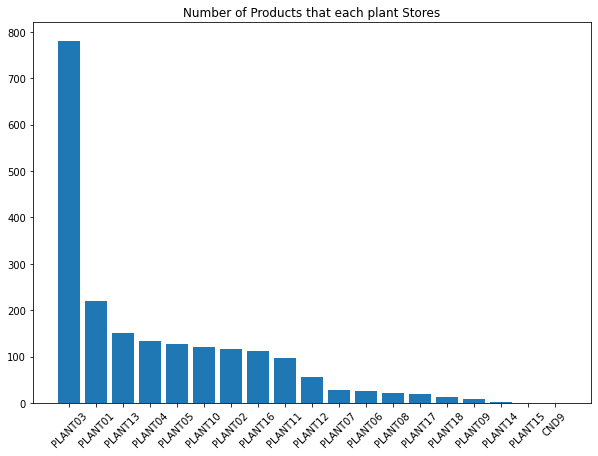

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
plant_counts = pd.DataFrame(products_plants["Plant_Code"].value_counts())
ax.bar(plant_counts.index, plant_counts["Plant_Code"])
plt.title("Number of Products that each plant Stores")
plt.show()

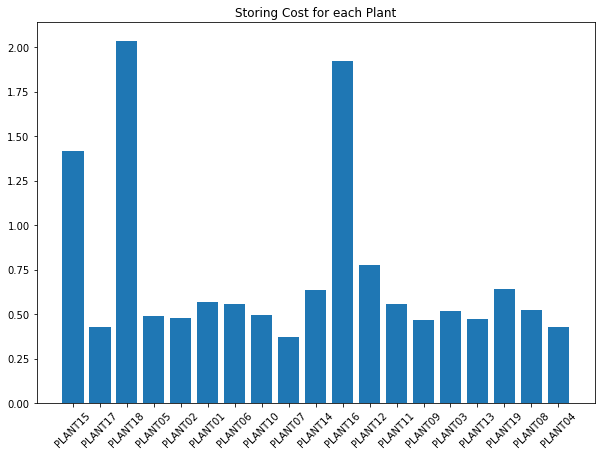

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
ax.bar(wh_cost.index, wh_cost["Cost/unit"])
plt.title("Storing Cost for each Plant")
plt.show()